In [50]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm


from sklearn import preprocessing

%matplotlib inline

In [51]:
path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'

In [52]:
os.listdir(path)

['calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [53]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

CPU times: user 11.9 s, sys: 1.22 s, total: 13.1 s
Wall time: 13.2 s


In [54]:
train_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4   ...    d_1904  d_1905  d_1906  d_1907  \
0       CA    0    0    0    0   ...         1       3       0       1   
1       CA    0    0    0    0   ...         0       0       0       0   
2       CA    0    0    0    0   ...         2       1       2       1   
3       CA    0    0    0    0   ...         1       0       5       4   
4       CA    0    0    0    0   ...         2       1       1       0   

   d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       1       3       0       1       1  
1       0       1       0       0       0       0  
2       1       1       0       1       1       1  
3       1       0       1       3       7       2  
4       1       1       2       2       2       4  

[5 rows x 1919 columns]

In [55]:
train_df.store_id.nunique()

10

In [56]:
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [57]:
sell_prices_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [58]:
d_cols = [f'd_{i}' for i in range(1,1914)]

In [59]:
data = train_df.set_index('id')[d_cols].T
data.reset_index(drop=True, inplace=True)

In [60]:
calendar_df.date = pd.to_datetime(calendar_df.date)

In [61]:
calendar_df2 = calendar_df[:1913]

In [62]:
data = pd.concat([
    calendar_df2[['date', 'weekday']],
    data
],axis=1)

In [63]:
train_df.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [64]:
corr_dict = {}
store_id = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
for store in tqdm(store_id):
    tmp_df = data.iloc[-84:,data.columns.str.contains(store)]
    mean = tmp_df.mean(axis=0)
    tmp_df = tmp_df.loc[:,mean>1.5]
    corr_dict[store] = tmp_df.iloc[-84:,tmp_df.columns.str.contains(store)].corr()

In [65]:
with open('corr_dict.pkl', mode='wb') as f:
    pickle.dump(corr_dict, f)

In [66]:
"""
for key, value in corr_dict.items():
    plt.figure(figsize=(30,30))
    sns.heatmap(value, cmap='coolwarm', annot=True)
    plt.show()
"""

"\nfor key, value in corr_dict.items():\n    plt.figure(figsize=(30,30))\n    sns.heatmap(value, cmap='coolwarm', annot=True)\n    plt.show()\n"

In [67]:
corr_dict.keys()

dict_keys(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'])

In [68]:
corr = corr_dict['CA_1']
a = corr[abs(corr)>0.5].isnull().mean(axis=1)
a = a.sort_values()

In [69]:
a.head()

FOODS_3_540_CA_1_validation    0.967192
FOODS_3_147_CA_1_validation    0.971129
FOODS_3_592_CA_1_validation    0.972441
FOODS_3_714_CA_1_validation    0.972441
FOODS_3_618_CA_1_validation    0.973753
dtype: float64

In [70]:
del train_df, calendar_df
gc.collect()

113

In [71]:
data2 = data.iloc[:,2:].rolling(45, min_periods=1).sum()
data3 = data.iloc[::-1,2:].rolling(45, min_periods=1).sum()

In [72]:
data3 = data3.iloc[::-1, :]

In [73]:
data2[data2==0]=np.nan
data3[data3==0]=np.nan

In [74]:
data2 = (data2+data3)/2

In [75]:
del data3

In [76]:
data2 = pd.concat([
    data.iloc[:,:2],
    data2
], axis=1)

In [77]:
data3 = data.copy()
data3[data2.isnull()]=np.nan
data2 = data3
del data3

In [78]:
data.head()

date    weekday  HOBBIES_1_001_CA_1_validation  \
0 2011-01-29   Saturday                              0   
1 2011-01-30     Sunday                              0   
2 2011-01-31     Monday                              0   
3 2011-02-01    Tuesday                              0   
4 2011-02-02  Wednesday                              0   

   HOBBIES_1_002_CA_1_validation  HOBBIES_1_003_CA_1_validation  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   HOBBIES_1_004_CA_1_validation  HOBBIES_1_005_CA_1_validation  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   HOBBIES_1_006_CA_1_validation  HOBBIES_1_007_CA_1_validation  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   HOBBIES_1_008_CA_1_validation             ...               \
0                             12             ...                
1                             15             ...                
2                              0             ...                
3                              0             ...                
4                              0             ...                

   FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
0                            0                           14   
1                            0                           11   
2                            0                            5   
3                            0                            6   
4                            0                            5   

   FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
0                            1                            0   
1                            1                            0   
2                            1                            0   
3                            1                            0   
4                            1                            0   

   FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
0                            4                            0   
1                            4                            0   
2                            2                            2   
3                            5                            2   
4                            2                            0   

   FOODS_3_824_WI_3_validation  FOODS_3_825_WI_3_validation  \
0                            0                            0   
1                            0                            6   
2                            0                            0   
3                            0                            2   
4                            0                            2   

   FOODS_3_826_WI_3_validation  FOODS_3_827_WI_3_validation  
0                            0                            0  
1                            0                            0  
2                            0                            0  
3                            0                            0  
4                            0                            0  

[5 rows x 30492 columns]

In [79]:
data2.head()

date    weekday  HOBBIES_1_001_CA_1_validation  \
0 2011-01-29   Saturday                            NaN   
1 2011-01-30     Sunday                            NaN   
2 2011-01-31     Monday                            NaN   
3 2011-02-01    Tuesday                            NaN   
4 2011-02-02  Wednesday                            NaN   

   HOBBIES_1_002_CA_1_validation  HOBBIES_1_003_CA_1_validation  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   HOBBIES_1_004_CA_1_validation  HOBBIES_1_005_CA_1_validation  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   HOBBIES_1_006_CA_1_validation  HOBBIES_1_007_CA_1_validation  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   HOBBIES_1_008_CA_1_validation             ...               \
0                           12.0             ...                
1                           15.0             ...                
2                            0.0             ...                
3                            0.0             ...                
4                            0.0             ...                

   FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
0                          NaN                         14.0   
1                          NaN                         11.0   
2                          NaN                          5.0   
3                          NaN                          6.0   
4                          NaN                          5.0   

   FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
0                            1                          NaN   
1                            1                          NaN   
2                            1                          NaN   
3                            1                          NaN   
4                            1                          NaN   

   FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
0                          4.0                          NaN   
1                          4.0                          NaN   
2                          2.0                          2.0   
3                          5.0                          2.0   
4                          2.0                          0.0   

   FOODS_3_824_WI_3_validation  FOODS_3_825_WI_3_validation  \
0                          NaN                          NaN   
1                          NaN                          6.0   
2                          NaN                          0.0   
3                          NaN                          2.0   
4                          NaN                          2.0   

   FOODS_3_826_WI_3_validation  FOODS_3_827_WI_3_validation  
0                          NaN                          NaN  
1                          NaN                          NaN  
2                          NaN                          NaN  
3                          NaN                          NaN  
4                          NaN                          NaN  

[5 rows x 30492 columns]

In [82]:
corr_dict.keys()

dict_keys(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'])

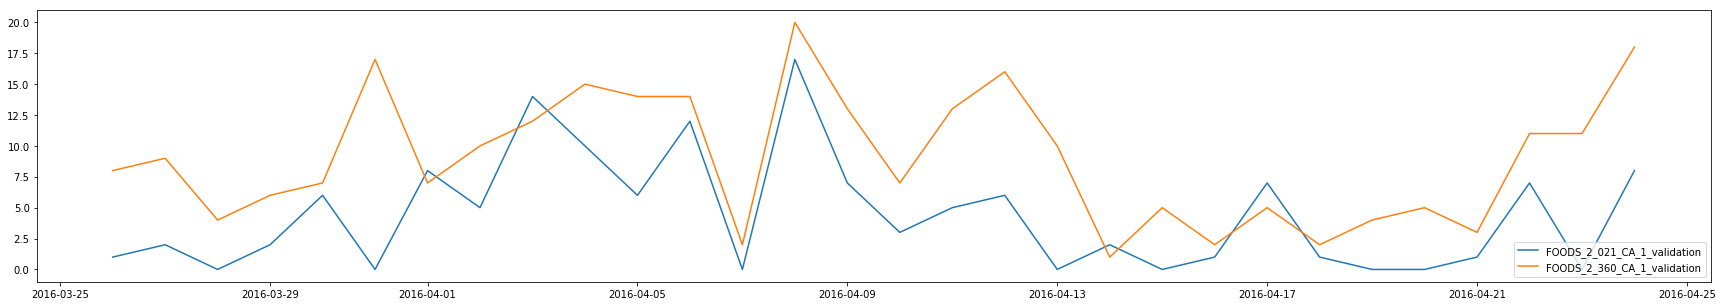

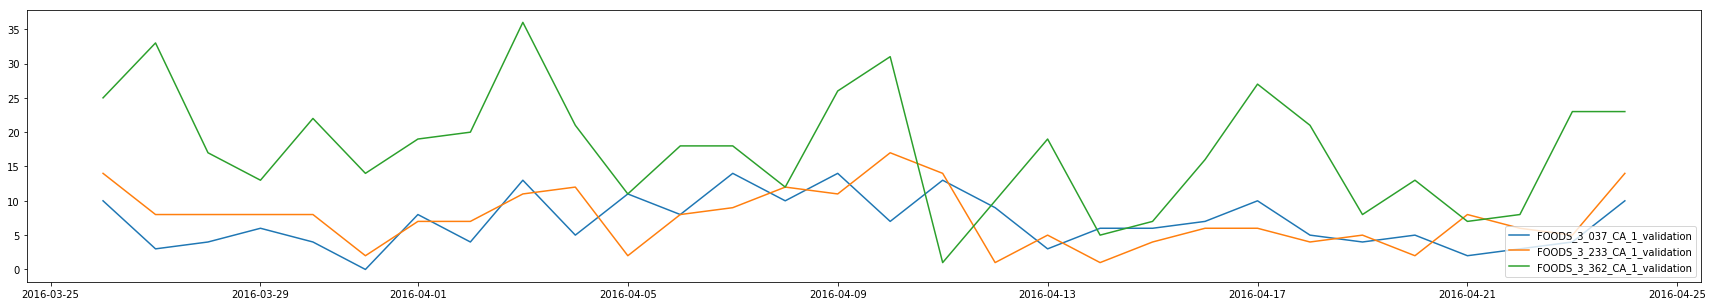

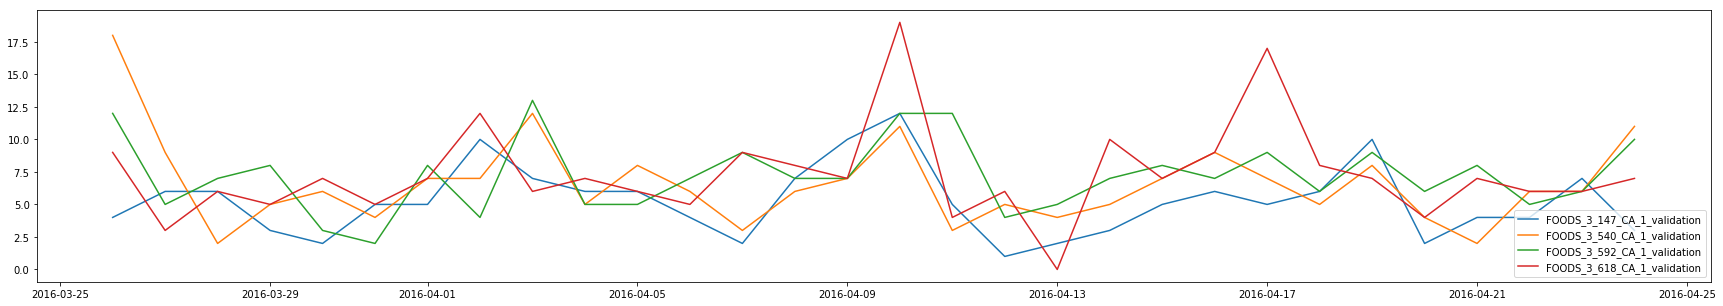

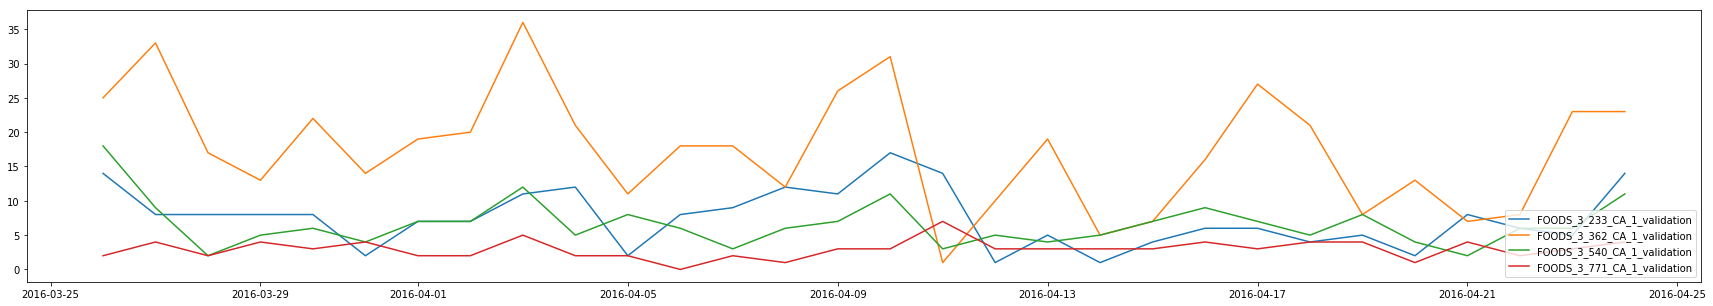

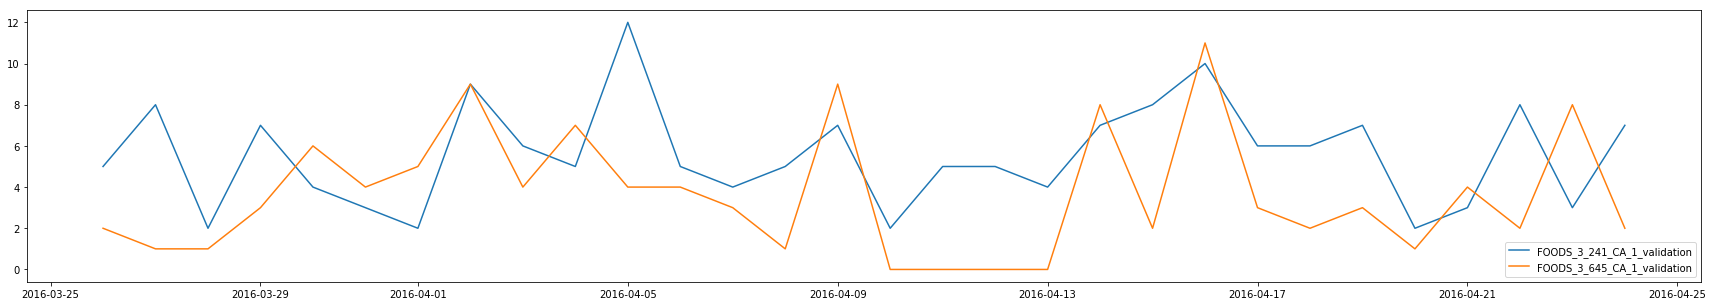

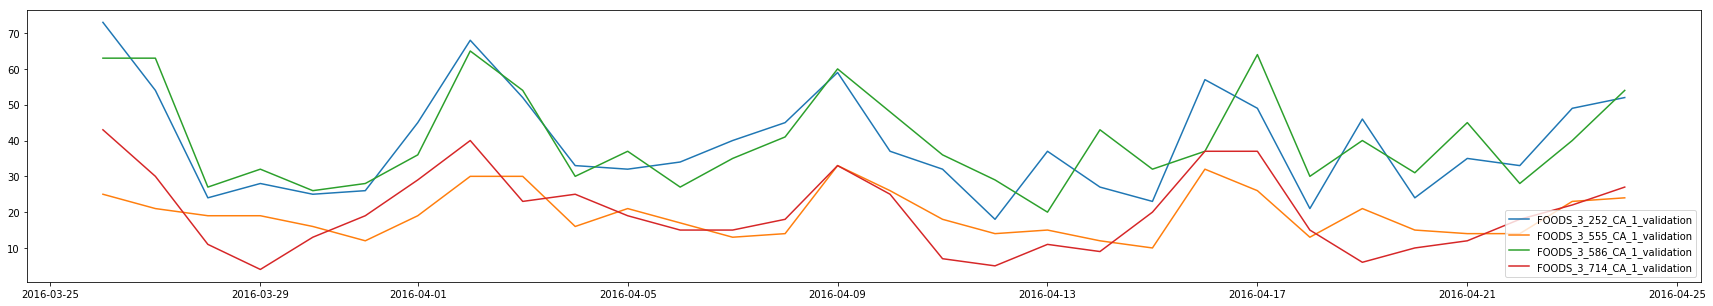

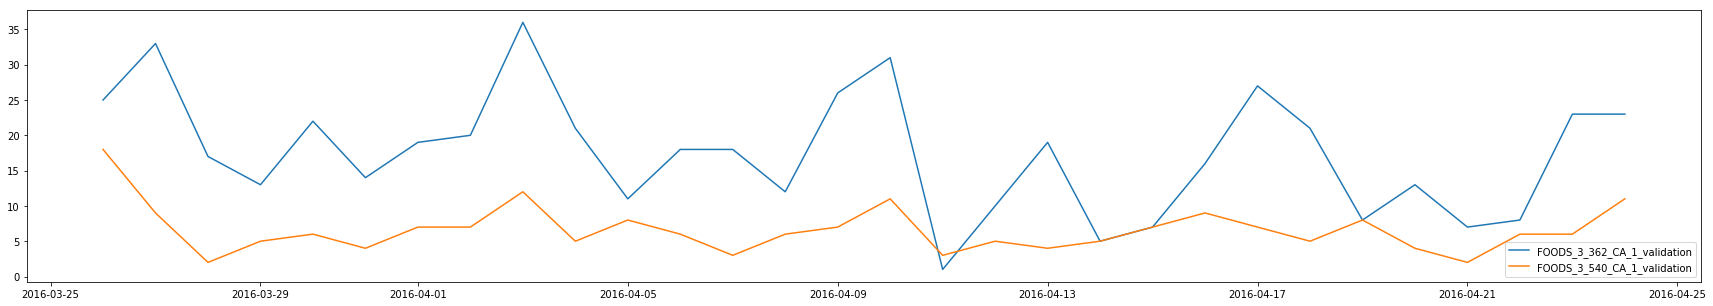

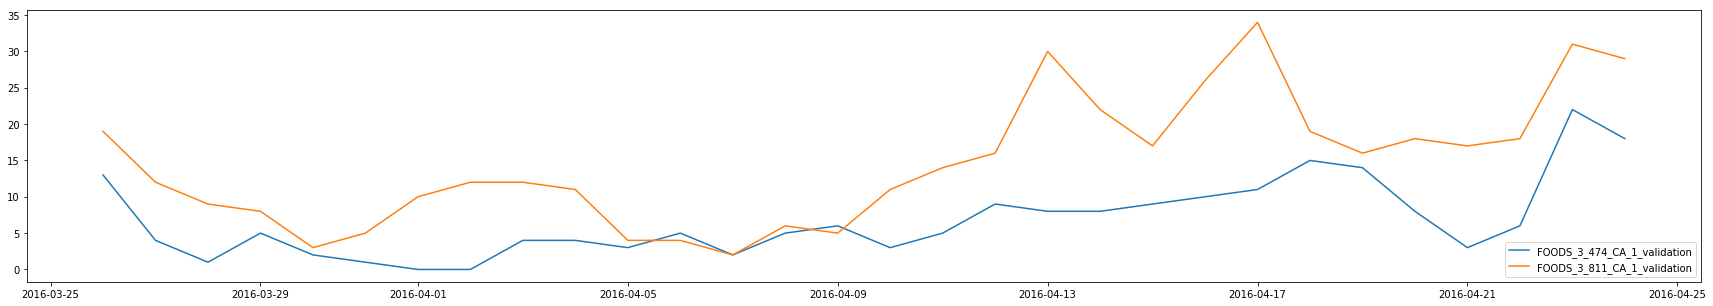

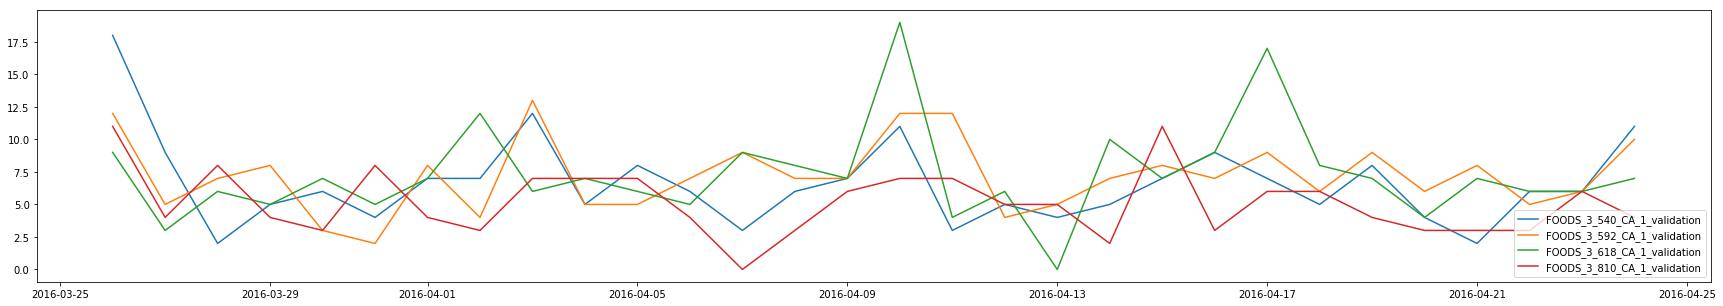

In [86]:
corr = corr_dict['CA_1']
col_corr={}
for i, col in enumerate(corr.columns[:-1]):
    col_corr[col]=[]
    for col2 in corr.columns[i+1:]:
        if corr.loc[col2, col]>0.7:
            col_corr[col].append(col2)
for col, col2 in col_corr.items():
    if len(col2)>0:
        plt.figure(figsize=(30,5))
        plt.plot(data['date'][-30:], data[col][-30:], label=col)
        for _col2 in col2:
            plt.plot(data['date'][-30:], data[_col2][-30:], label=_col2)
        try:
            plt.legend(loc=4)
        except:
            pass
        plt.show()

HOUSEHOLD_1_389_CA_2_validation ['HOUSEHOLD_1_414_CA_2_validation']


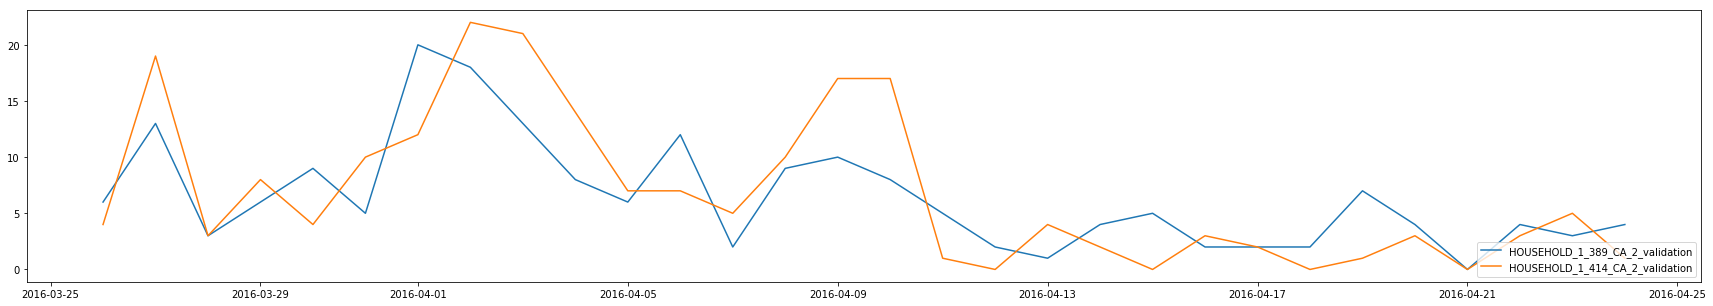

HOUSEHOLD_1_414_CA_2_validation ['HOUSEHOLD_1_521_CA_2_validation']


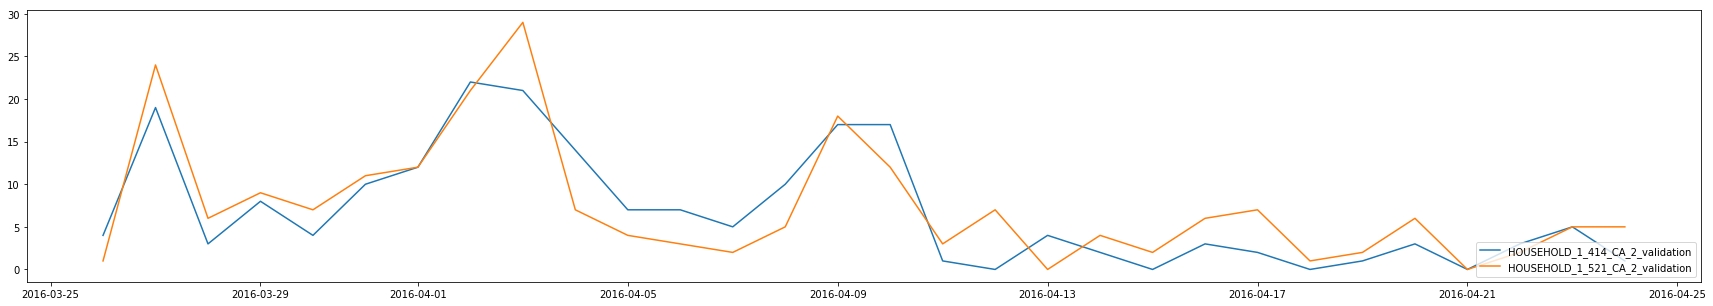

FOODS_3_066_CA_2_validation ['FOODS_3_127_CA_2_validation', 'FOODS_3_230_CA_2_validation', 'FOODS_3_516_CA_2_validation', 'FOODS_3_540_CA_2_validation']


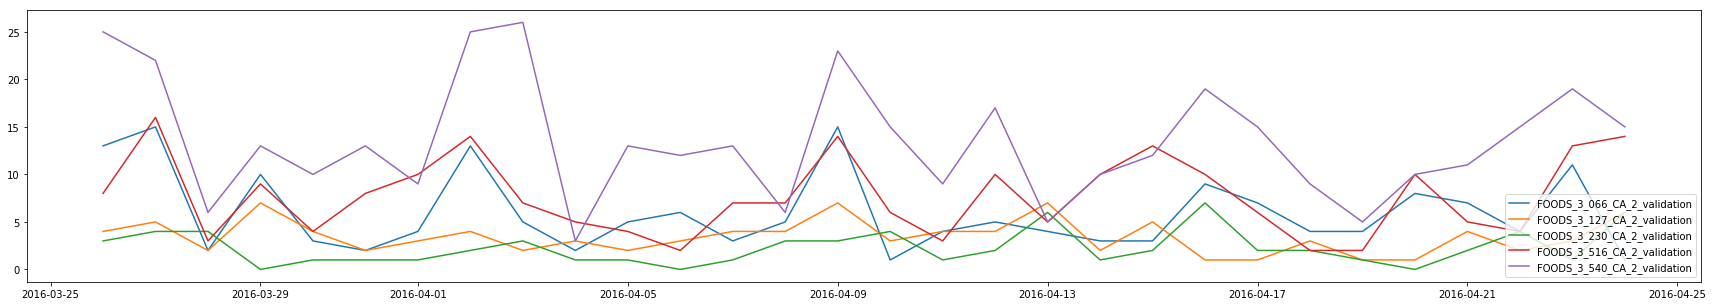

FOODS_3_070_CA_2_validation ['FOODS_3_547_CA_2_validation']


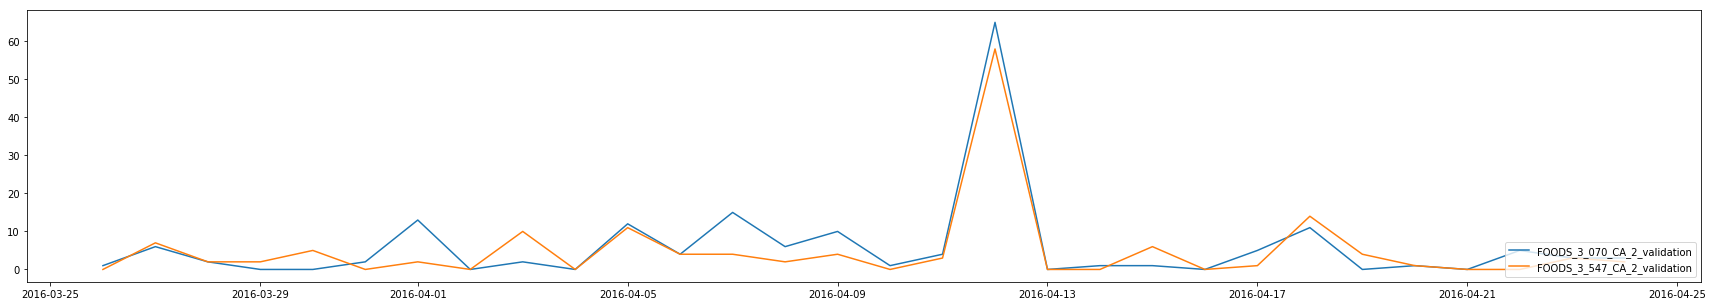

FOODS_3_090_CA_2_validation ['FOODS_3_723_CA_2_validation']


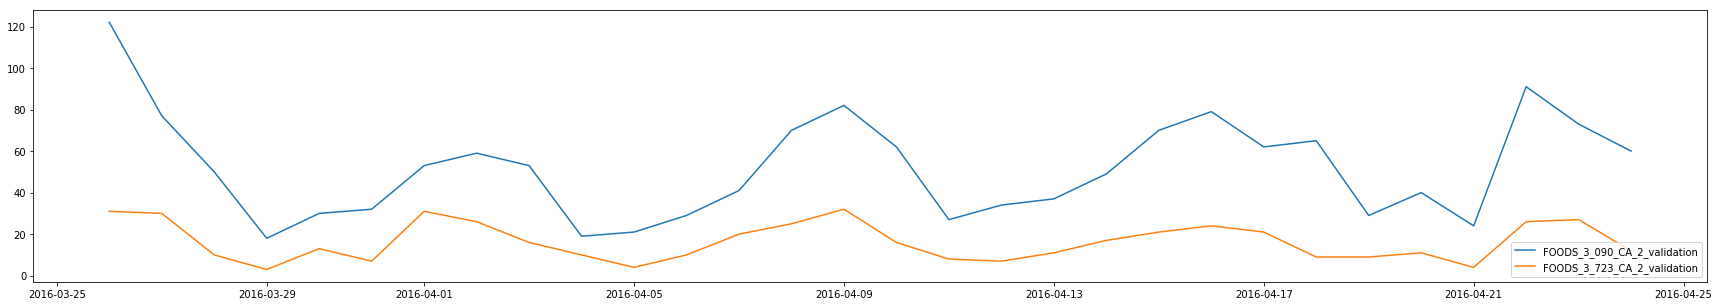

FOODS_3_127_CA_2_validation ['FOODS_3_516_CA_2_validation']


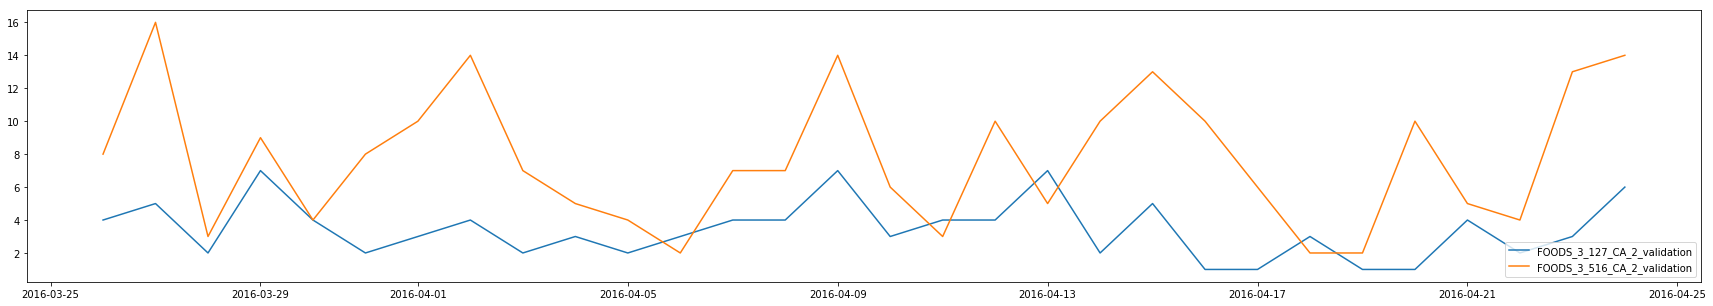

FOODS_3_230_CA_2_validation ['FOODS_3_516_CA_2_validation', 'FOODS_3_540_CA_2_validation']


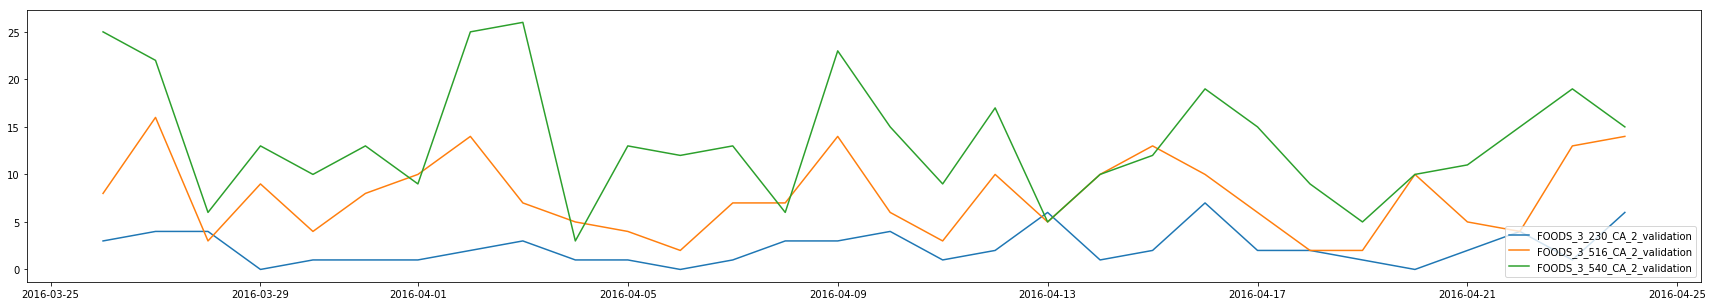

FOODS_3_233_CA_2_validation ['FOODS_3_362_CA_2_validation']


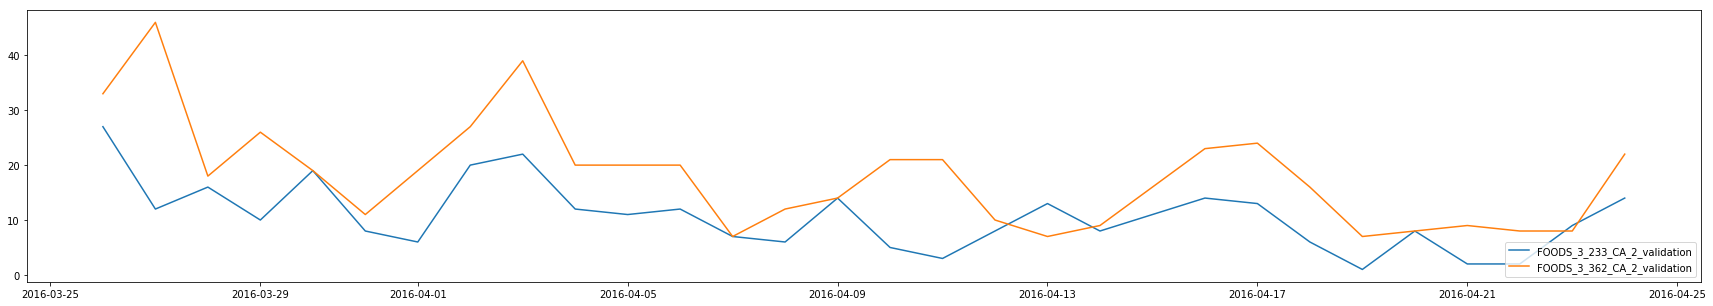

FOODS_3_252_CA_2_validation ['FOODS_3_714_CA_2_validation']


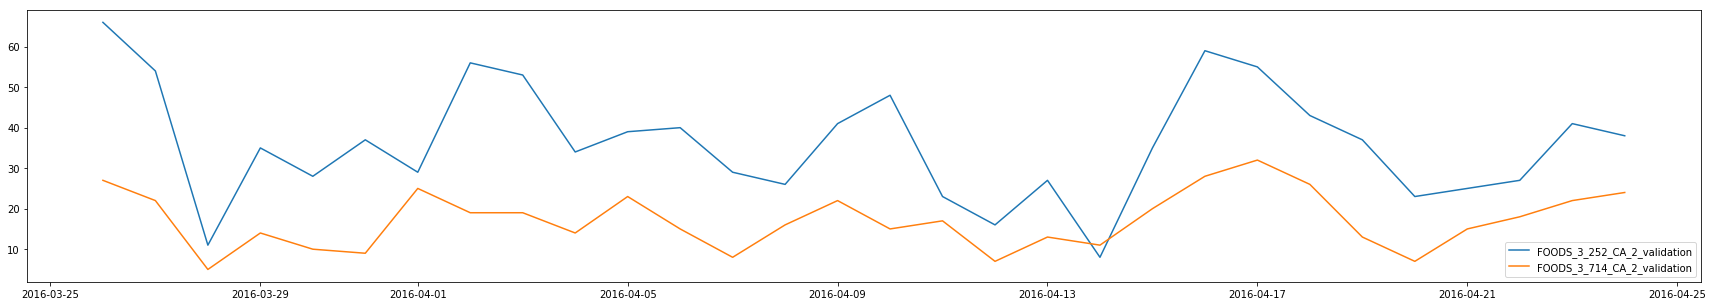

FOODS_3_288_CA_2_validation ['FOODS_3_739_CA_2_validation']


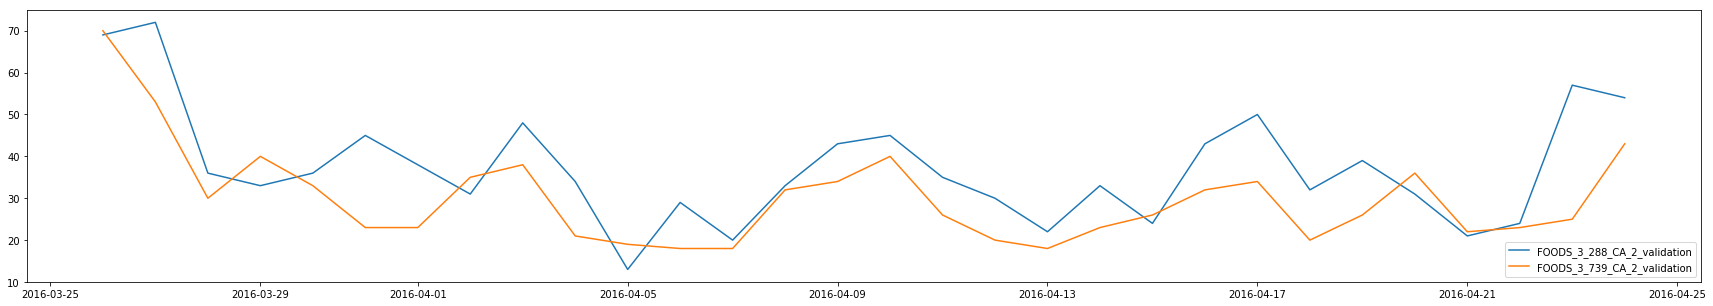

FOODS_3_319_CA_2_validation ['FOODS_3_541_CA_2_validation', 'FOODS_3_635_CA_2_validation', 'FOODS_3_767_CA_2_validation']


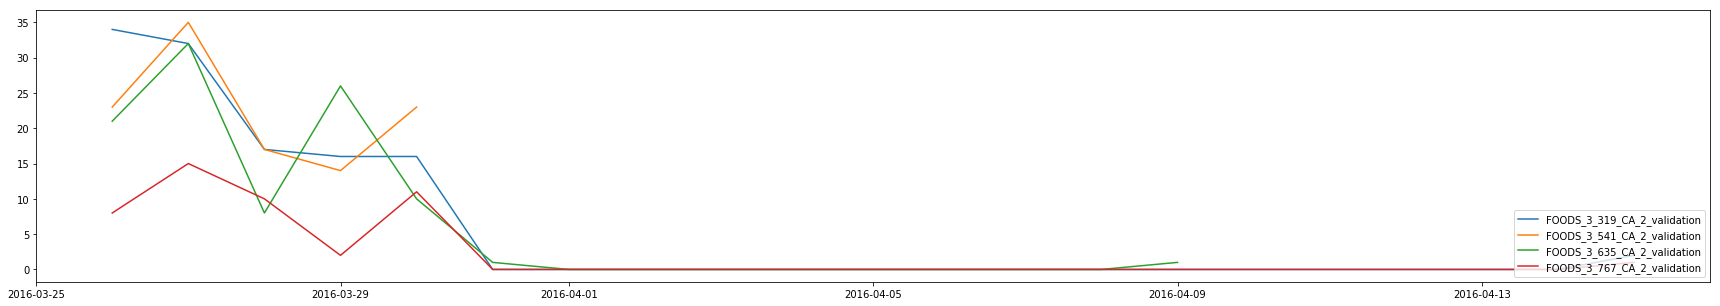

FOODS_3_362_CA_2_validation ['FOODS_3_592_CA_2_validation']


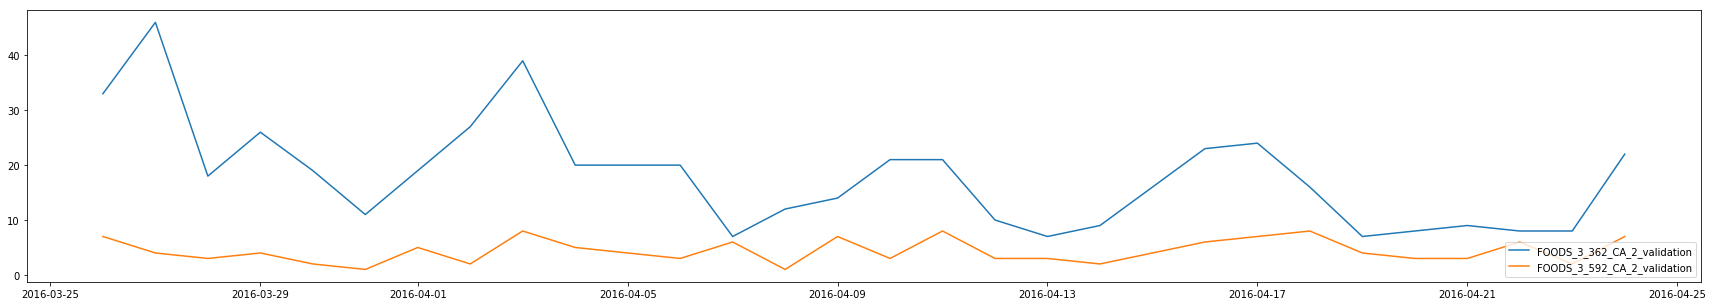

FOODS_3_516_CA_2_validation ['FOODS_3_540_CA_2_validation']


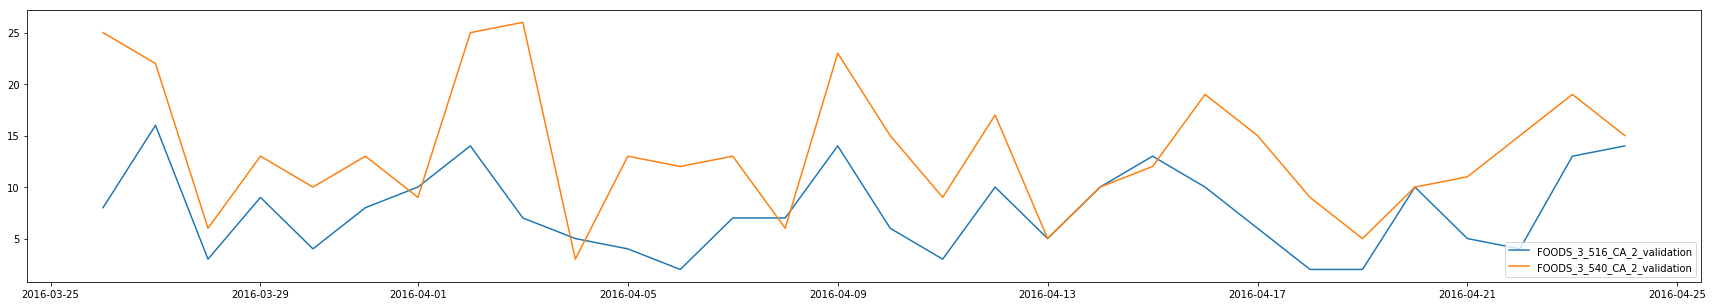

FOODS_3_540_CA_2_validation ['FOODS_3_634_CA_2_validation']


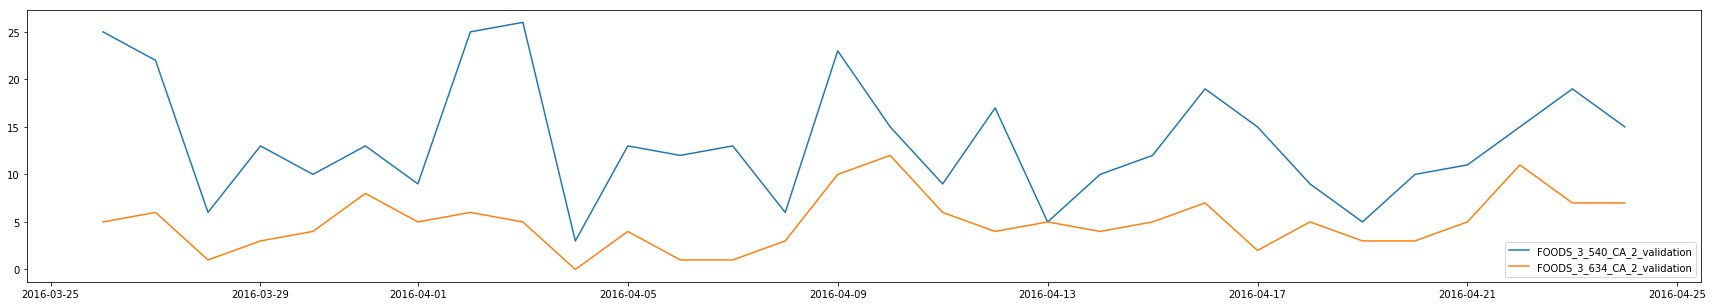

FOODS_3_541_CA_2_validation ['FOODS_3_635_CA_2_validation']


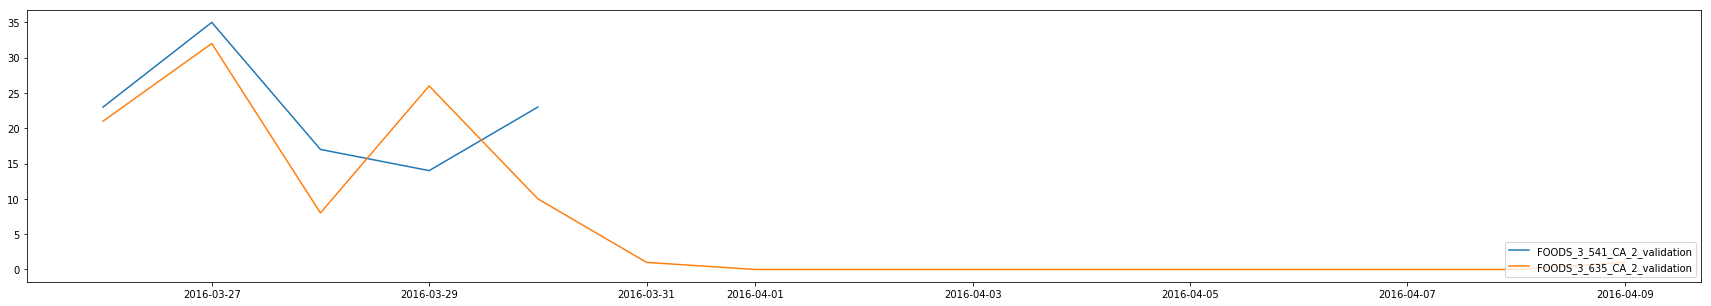

FOODS_3_635_CA_2_validation ['FOODS_3_767_CA_2_validation']


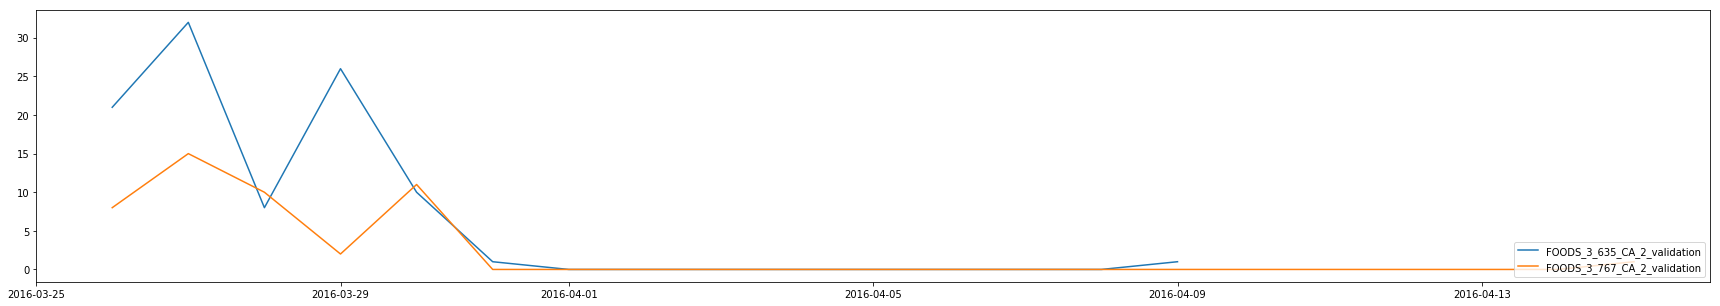

In [90]:
corr = corr_dict['CA_2']
col_corr={}
for i, col in enumerate(corr.columns[:-1]):
    col_corr[col]=[]
    for col2 in corr.columns[i+1:]:
        if corr.loc[col2, col]>0.7:
            col_corr[col].append(col2)
for col, col2 in col_corr.items():
    if len(col2)>0:
        plt.figure(figsize=(30,5))
        plt.plot(data['date'][-30:], data[col][-30:], label=col)
        for _col2 in col2:
            plt.plot(data['date'][-30:], data[_col2][-30:], label=_col2)
        try:
            plt.legend(loc=4)
        except:
            pass
        print(col, col2)
        plt.show()

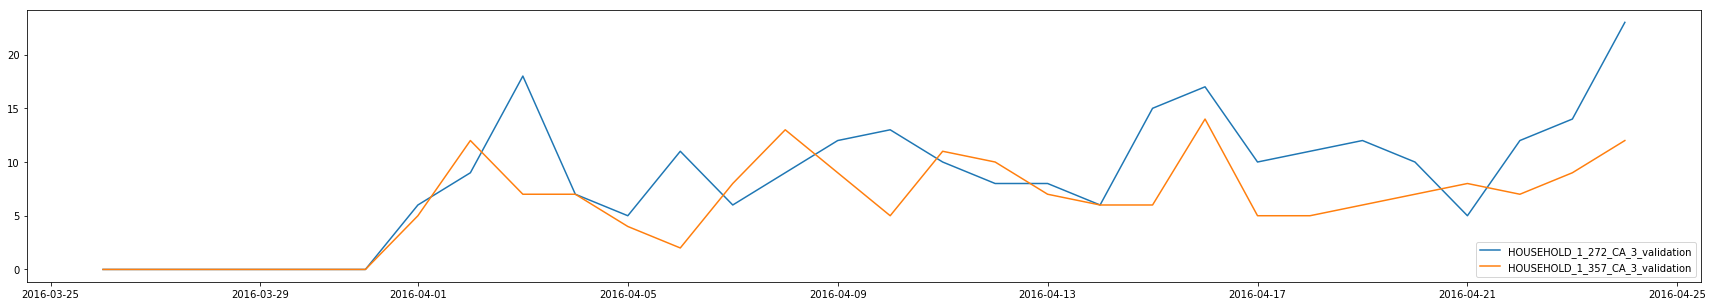

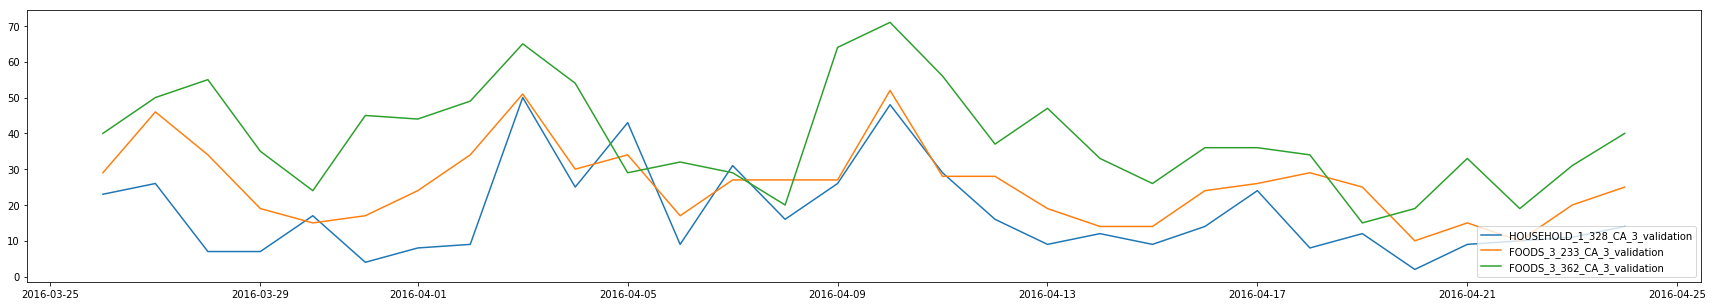

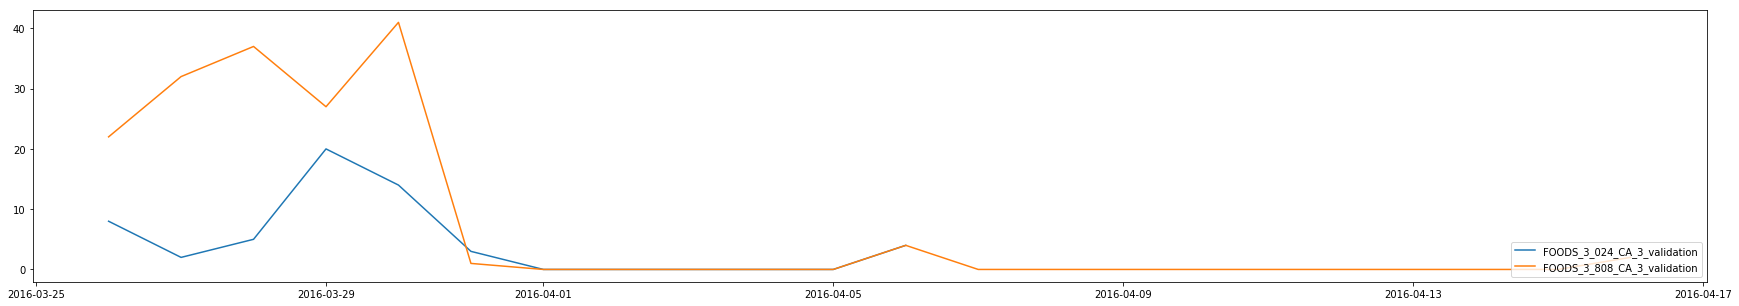

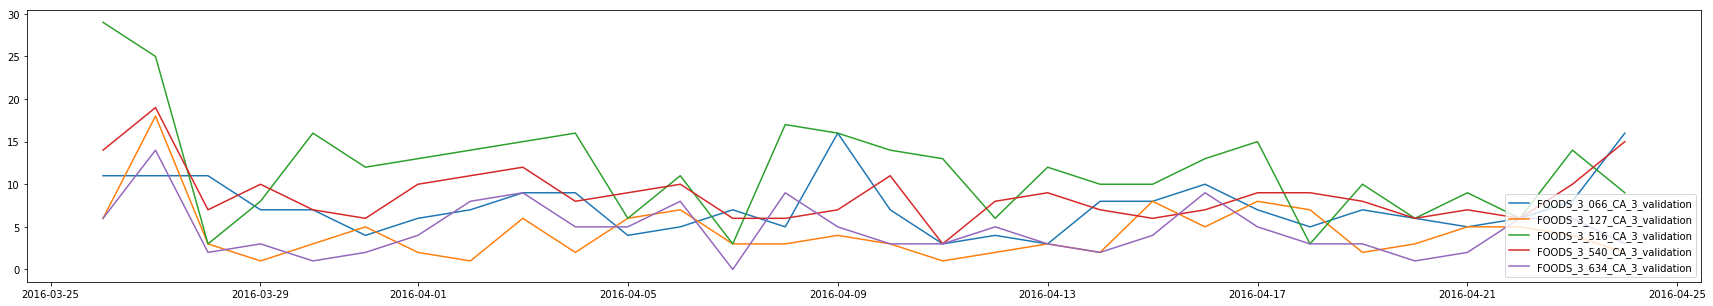

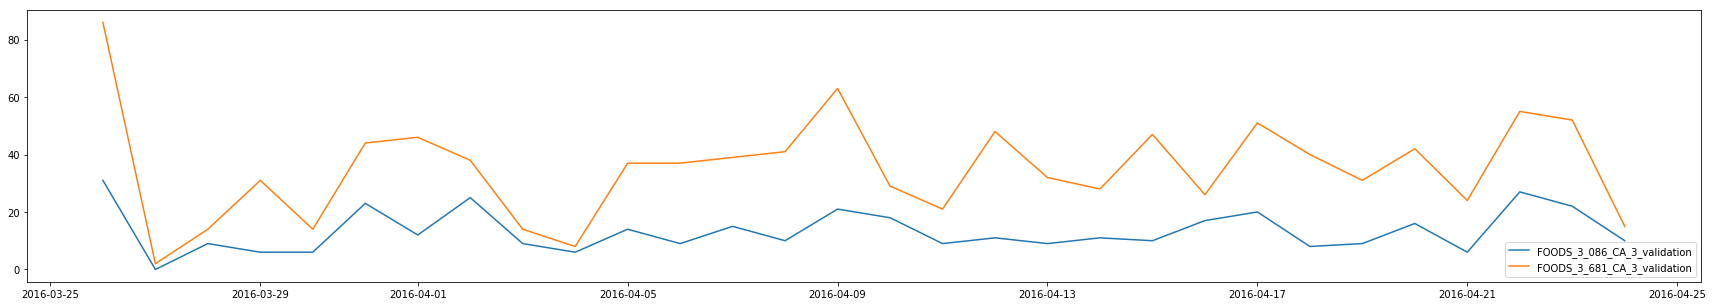

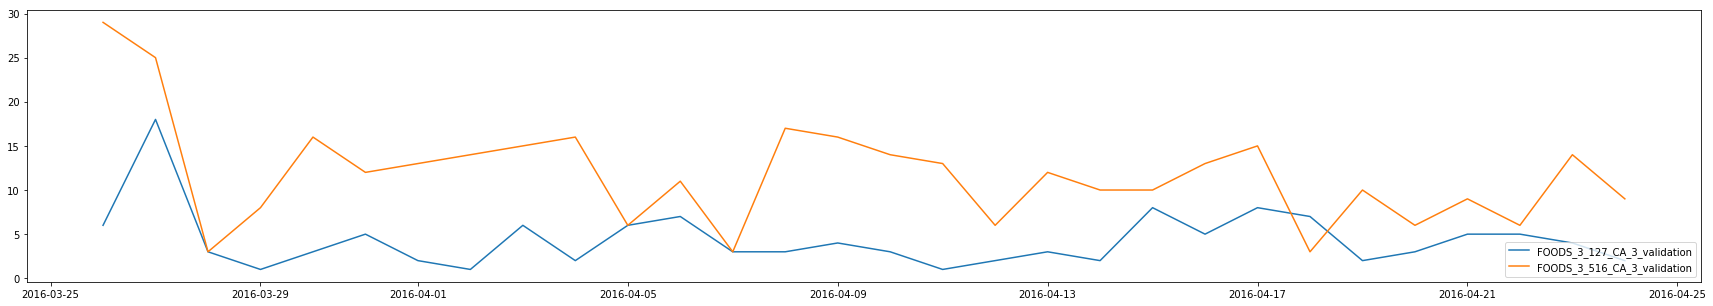

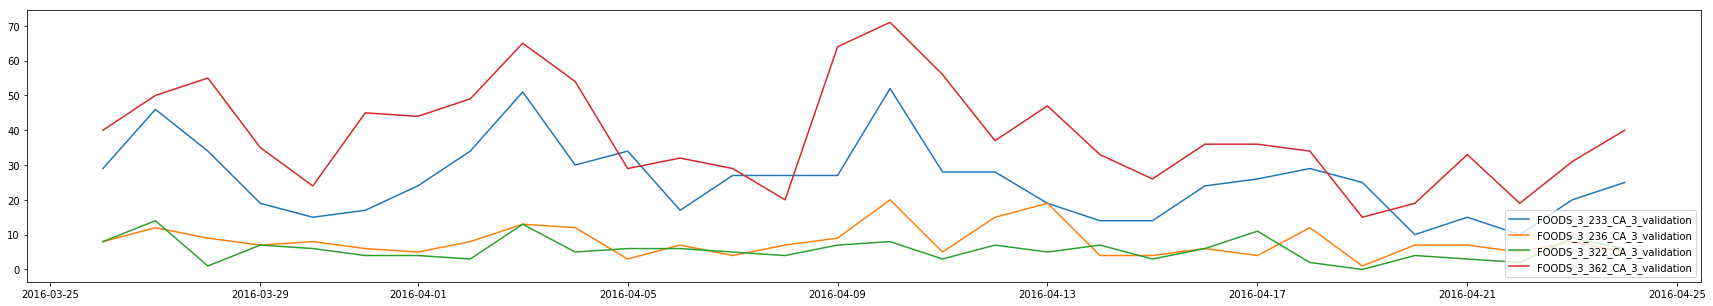

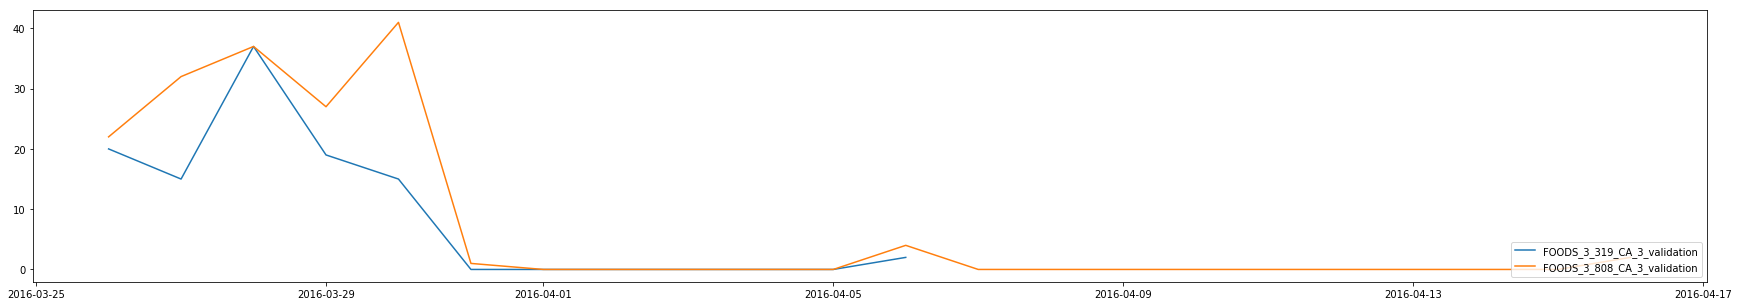

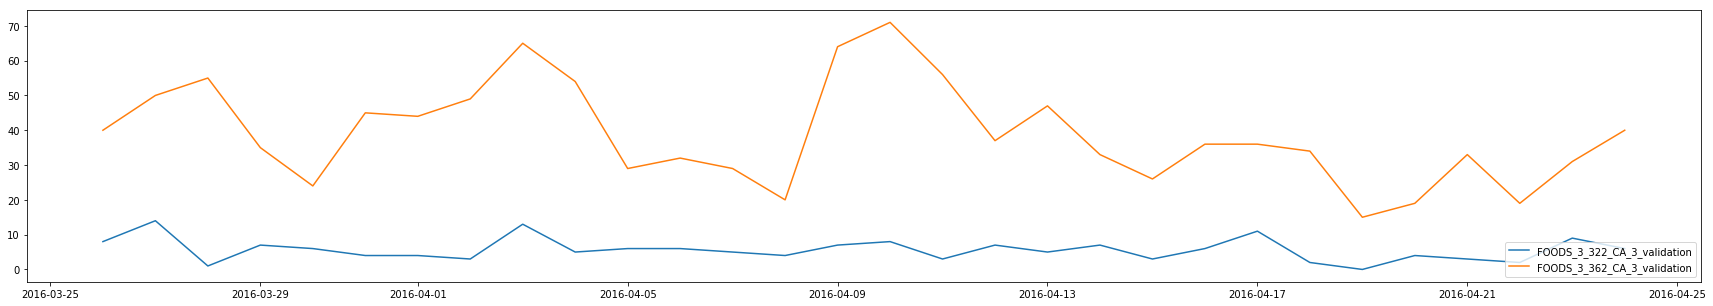

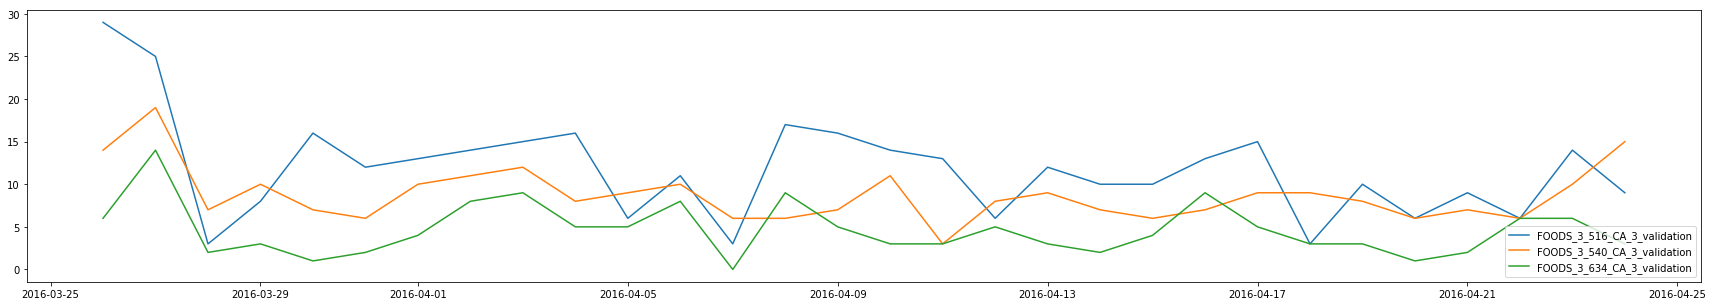

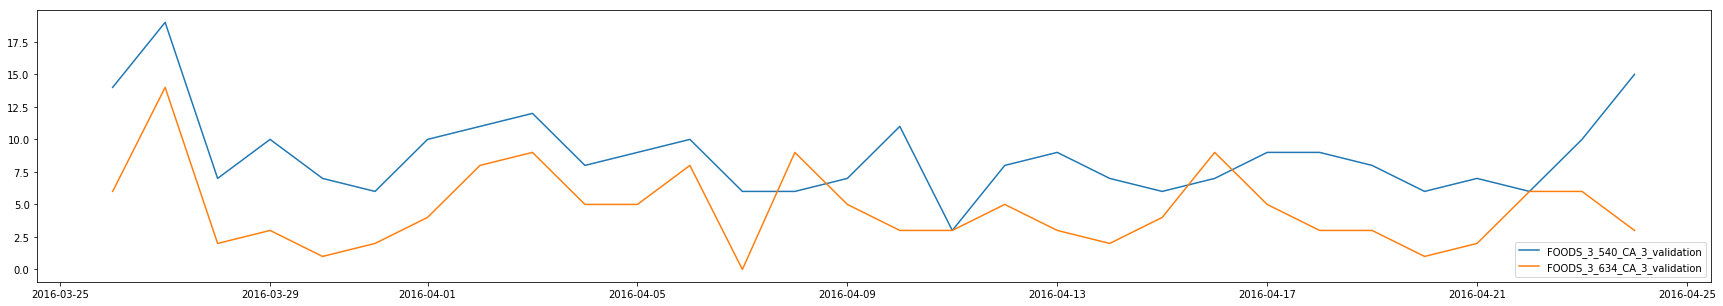

In [88]:
corr = corr_dict['CA_3']
col_corr={}
for i, col in enumerate(corr.columns[:-1]):
    col_corr[col]=[]
    for col2 in corr.columns[i+1:]:
        if corr.loc[col2, col]>0.7:
            col_corr[col].append(col2)
for col, col2 in col_corr.items():
    if len(col2)>0:
        plt.figure(figsize=(30,5))
        plt.plot(data['date'][-30:], data[col][-30:], label=col)
        for _col2 in col2:
            plt.plot(data['date'][-30:], data[_col2][-30:], label=_col2)
        try:
            plt.legend(loc=4)
        except:
            pass
        plt.show()

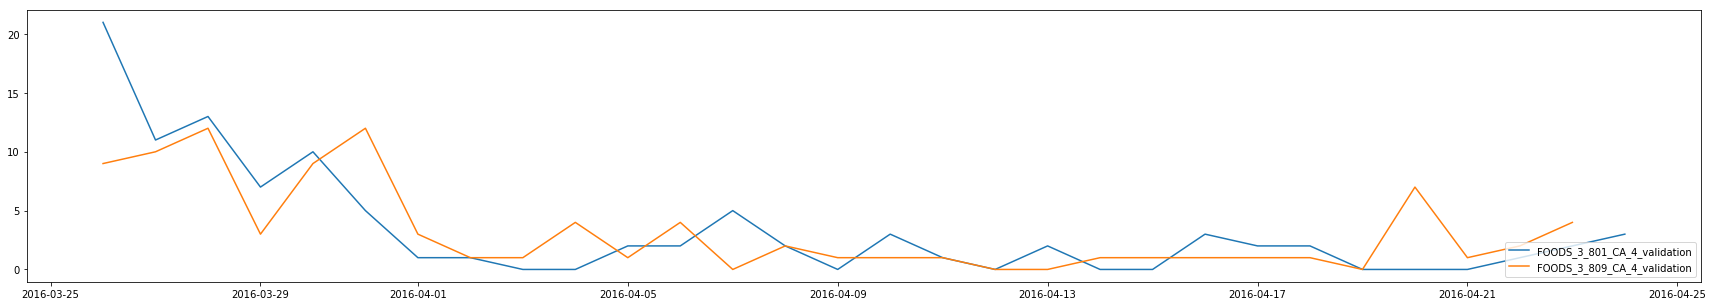

In [89]:
corr = corr_dict['CA_4']
col_corr={}
for i, col in enumerate(corr.columns[:-1]):
    col_corr[col]=[]
    for col2 in corr.columns[i+1:]:
        if corr.loc[col2, col]>0.7:
            col_corr[col].append(col2)
for col, col2 in col_corr.items():
    if len(col2)>0:
        plt.figure(figsize=(30,5))
        plt.plot(data['date'][-30:], data[col][-30:], label=col)
        for _col2 in col2:
            plt.plot(data['date'][-30:], data[_col2][-30:], label=_col2)
        try:
            plt.legend(loc=4)
        except:
            pass
        plt.show()

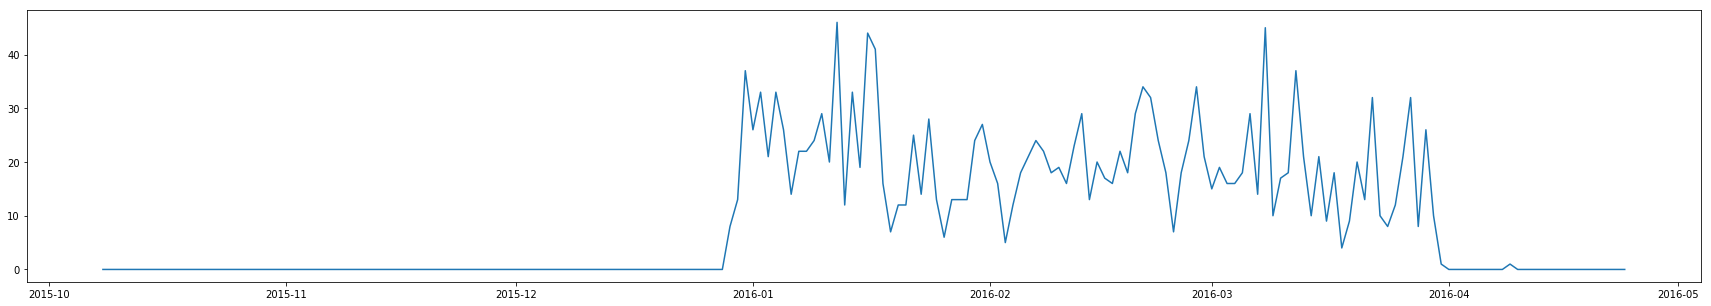

1876.0

In [134]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-200:], data['FOODS_3_635_CA_2_validation'][-200:])
plt.show()
data2['FOODS_3_635_CA_2_validation'][-200:].dropna().sum()

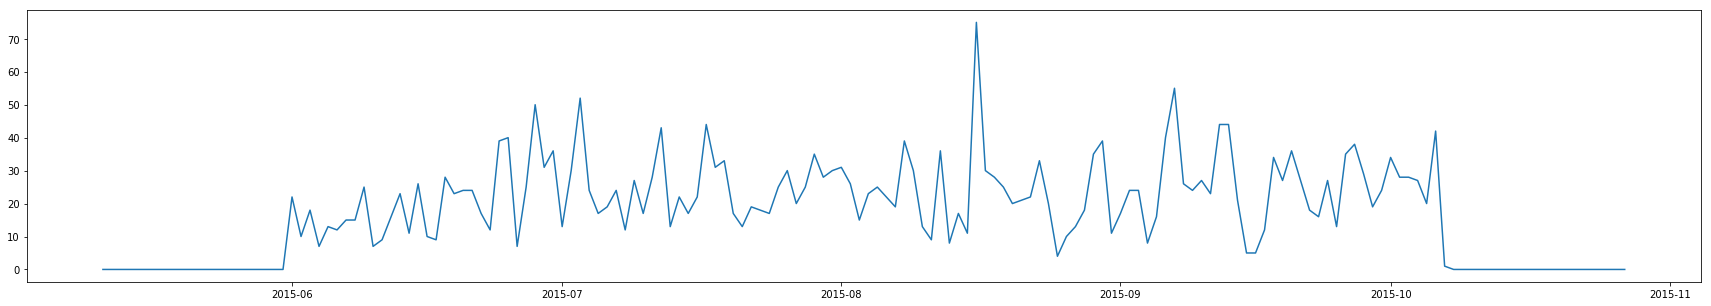

3035.0

In [133]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-350:-180], data['FOODS_3_635_CA_2_validation'][-350:-180])
plt.show()
data2['FOODS_3_635_CA_2_validation'][-350:-180].dropna().sum()

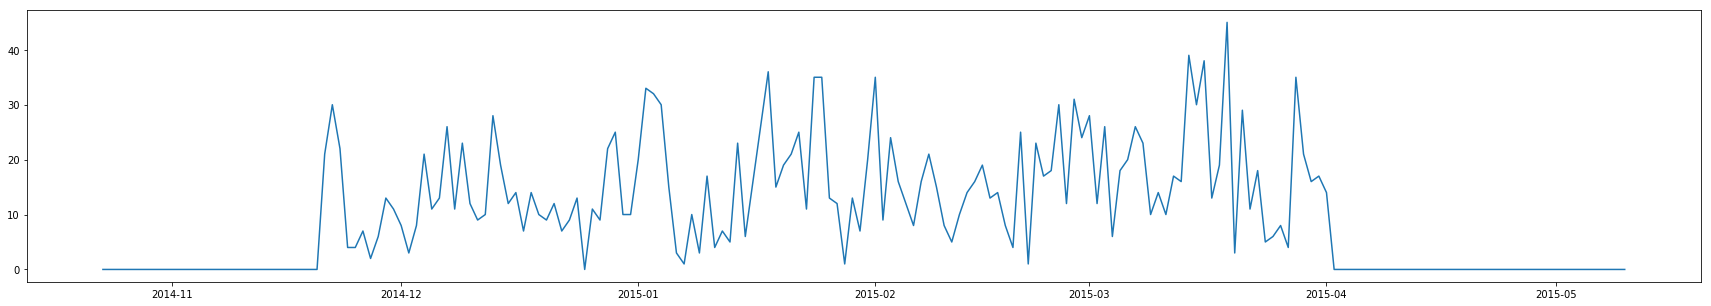

2075.0

In [136]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-550:-350], data['FOODS_3_635_CA_2_validation'][-550:-350])
plt.show()
data2['FOODS_3_635_CA_2_validation'][-550:-350].dropna().sum()

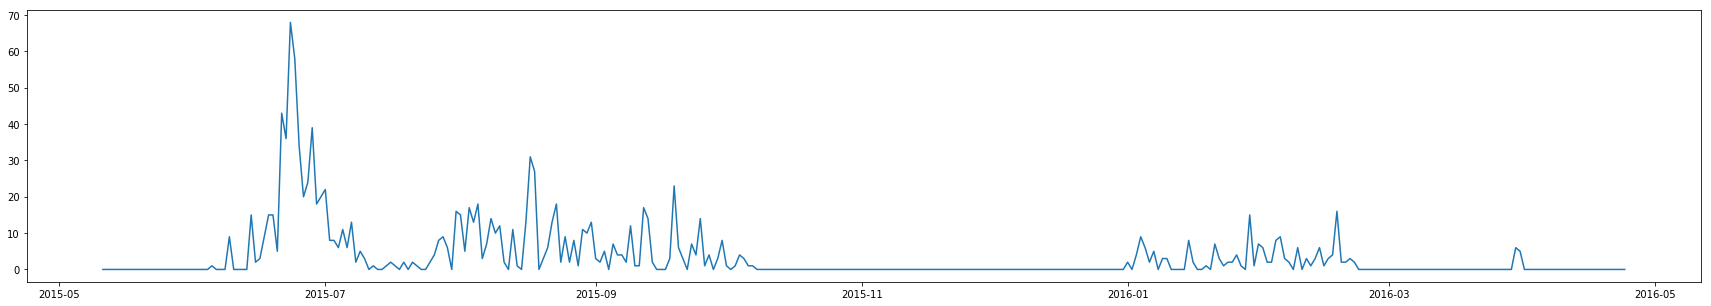

1029.0

In [140]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-350:], data['FOODS_3_635_CA_1_validation'][-350:])
plt.show()
data2['FOODS_3_635_CA_1_validation'][-350:-180].dropna().sum()

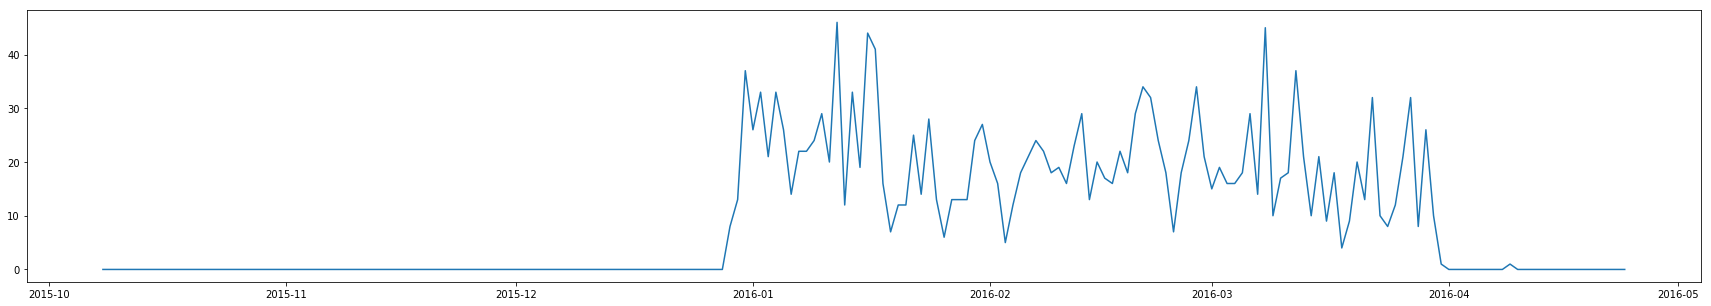

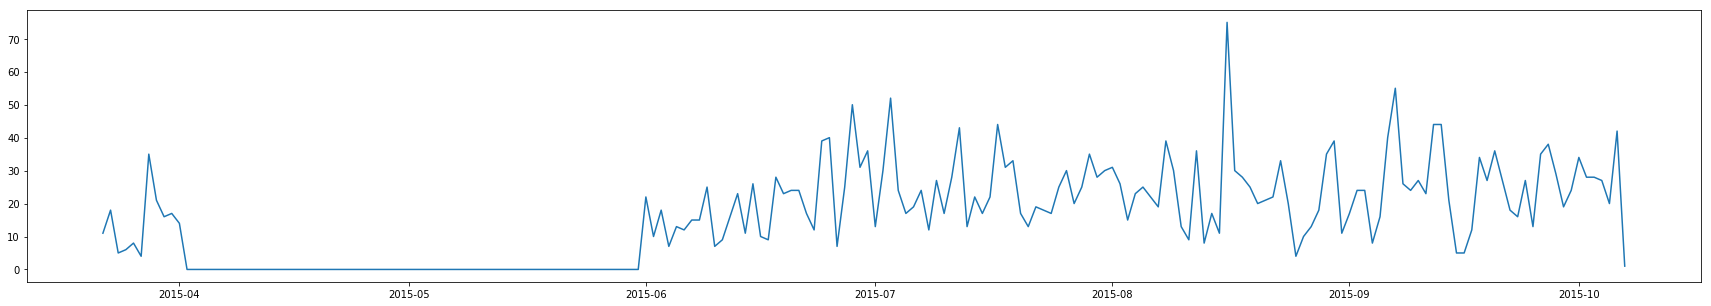

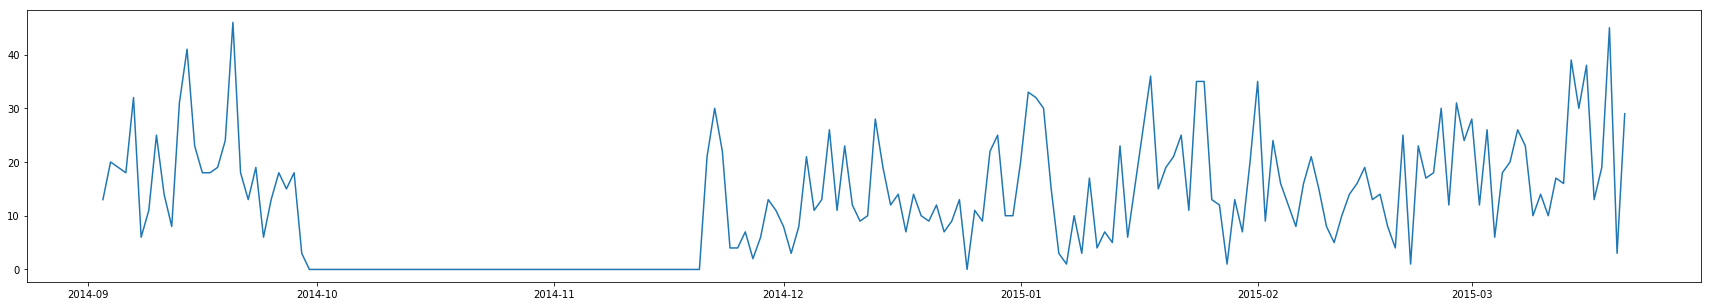

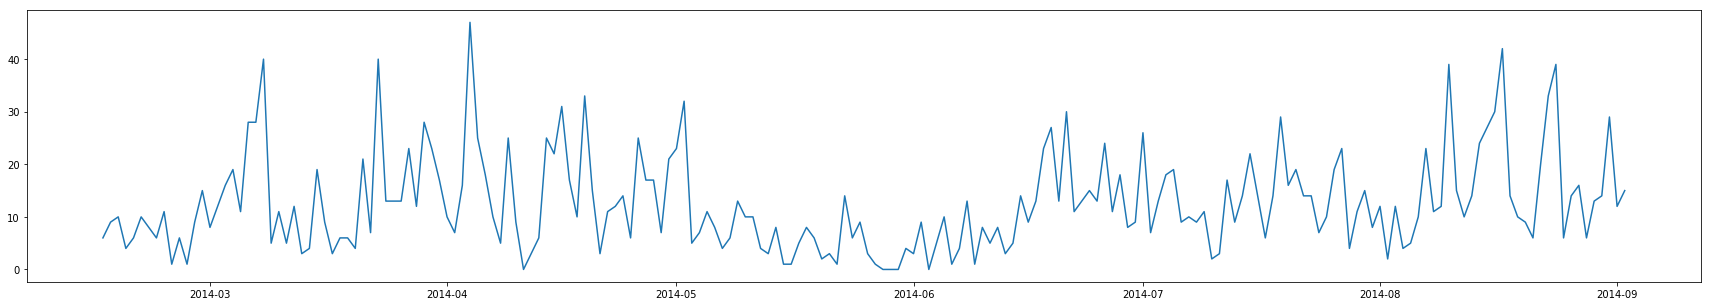

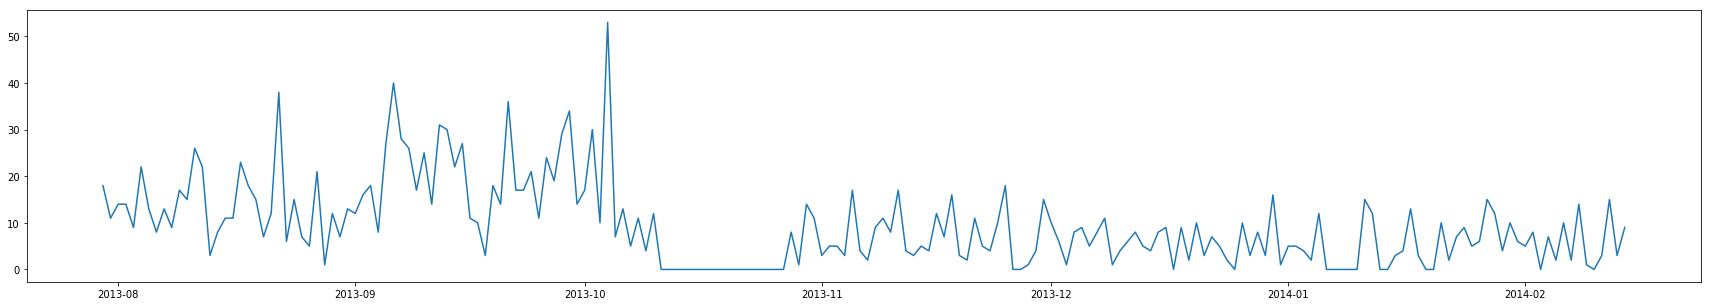

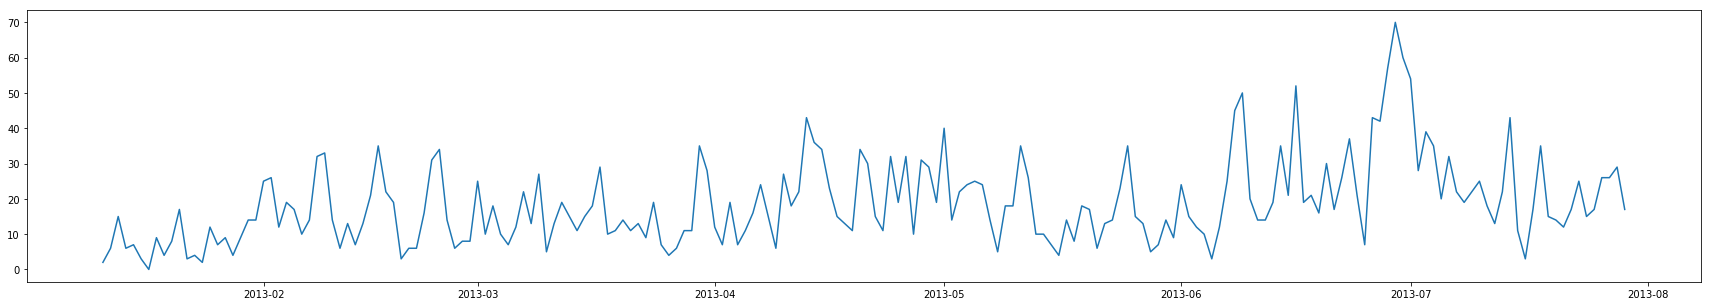

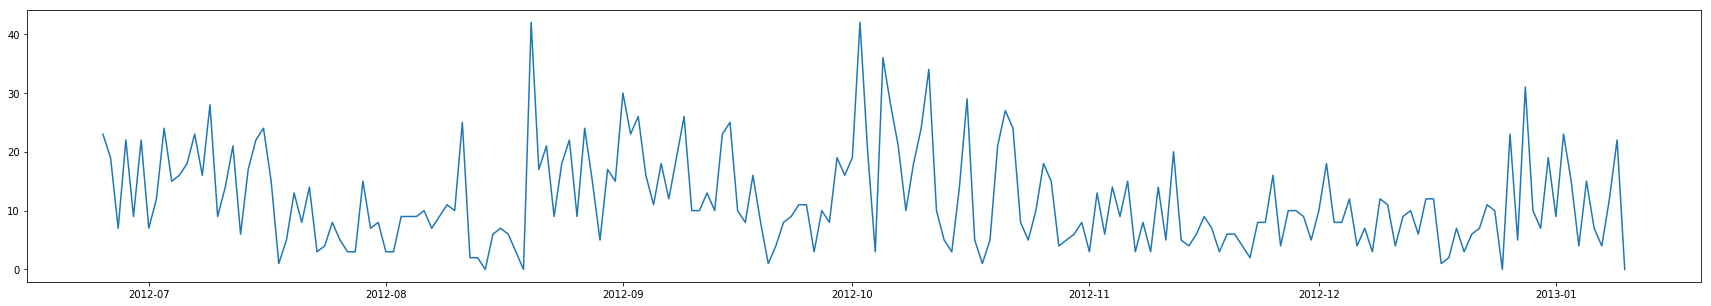

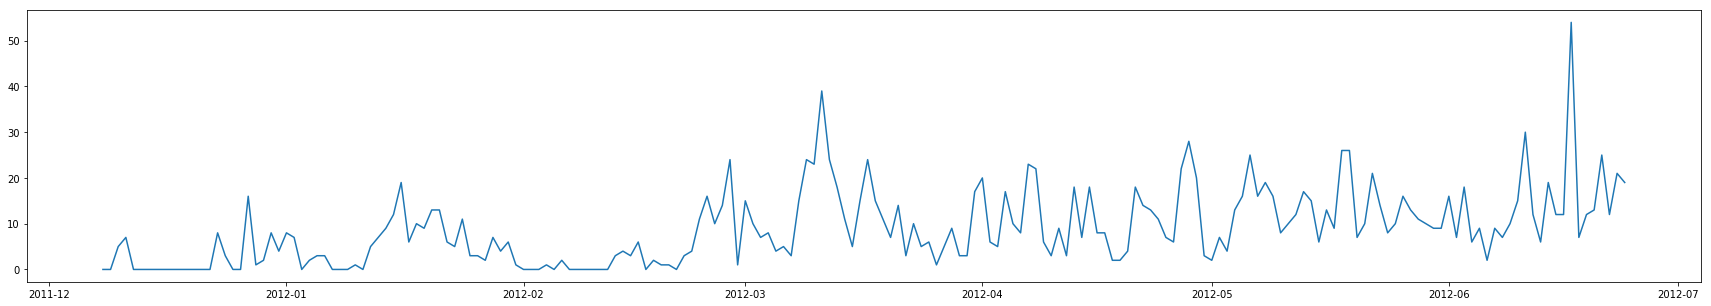

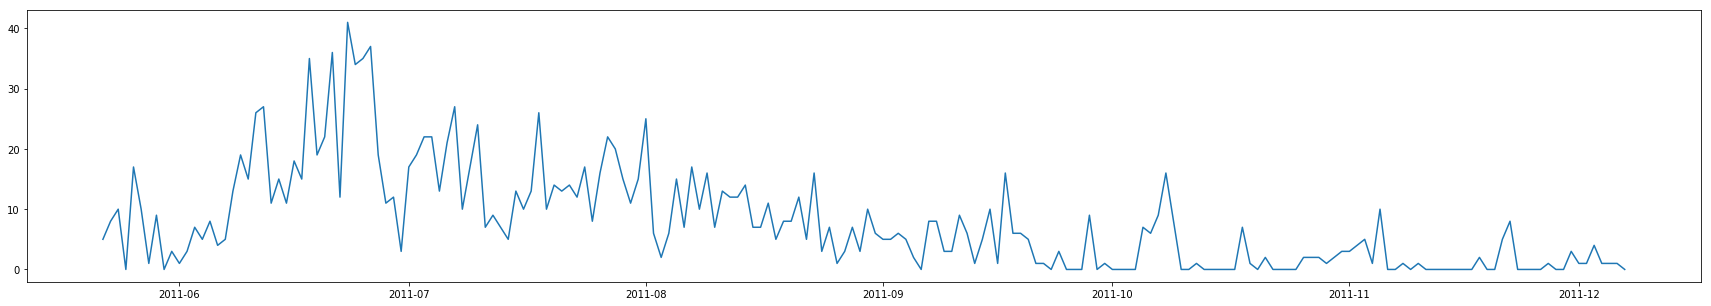

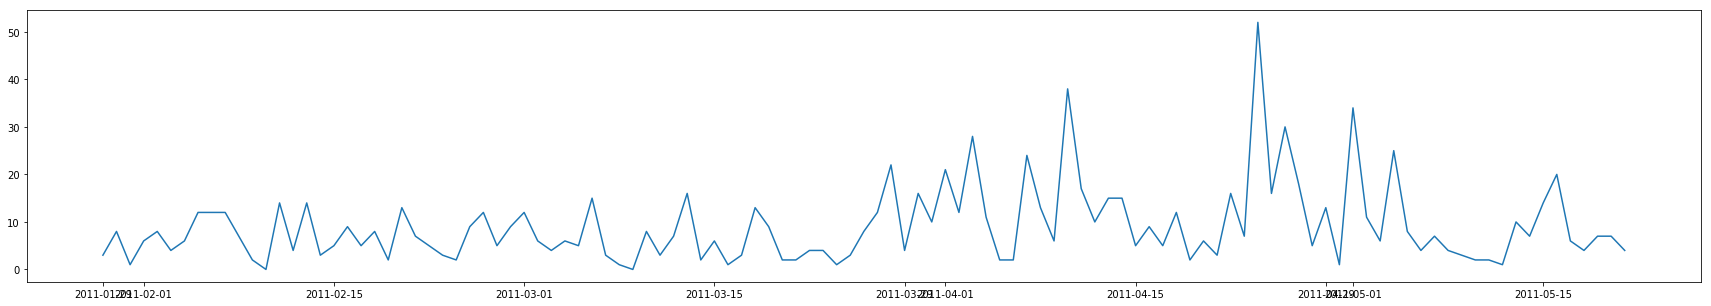

In [112]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-200:], data['FOODS_3_635_CA_2_validation'][-200:])
plt.show()

for i in range(1,10):
    plt.figure(figsize=(30,5))
    plt.plot(data.date[-200*(i+1):-200*i], data['FOODS_3_635_CA_2_validation'][-200*(i+1):-200*i])
    plt.show()

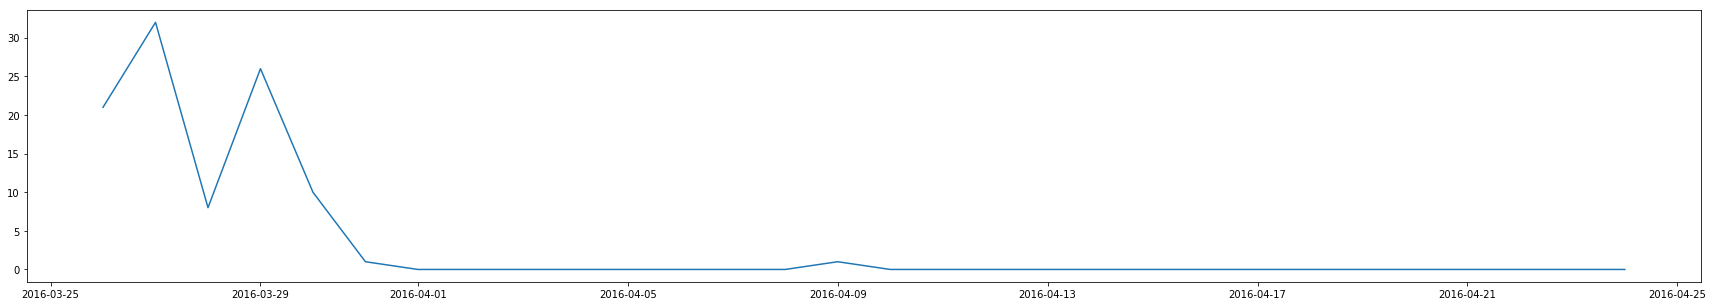

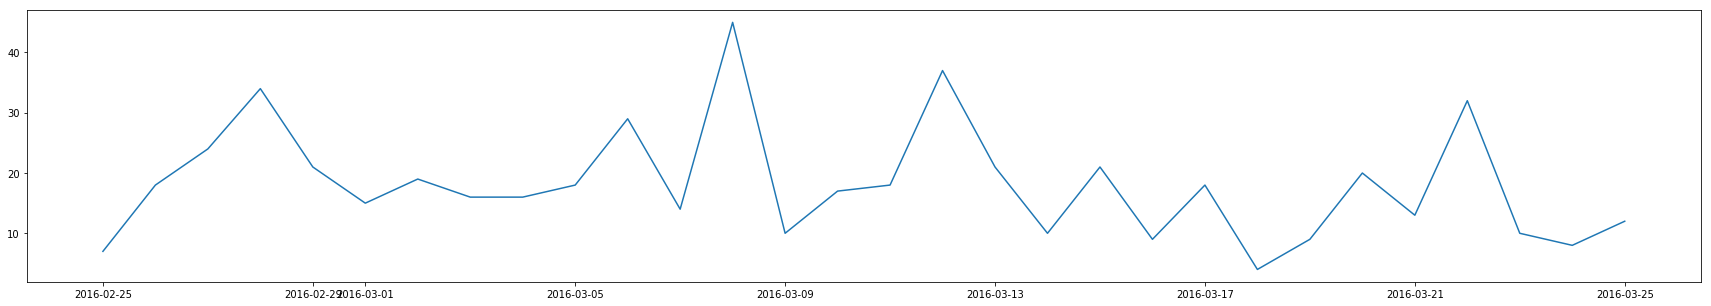

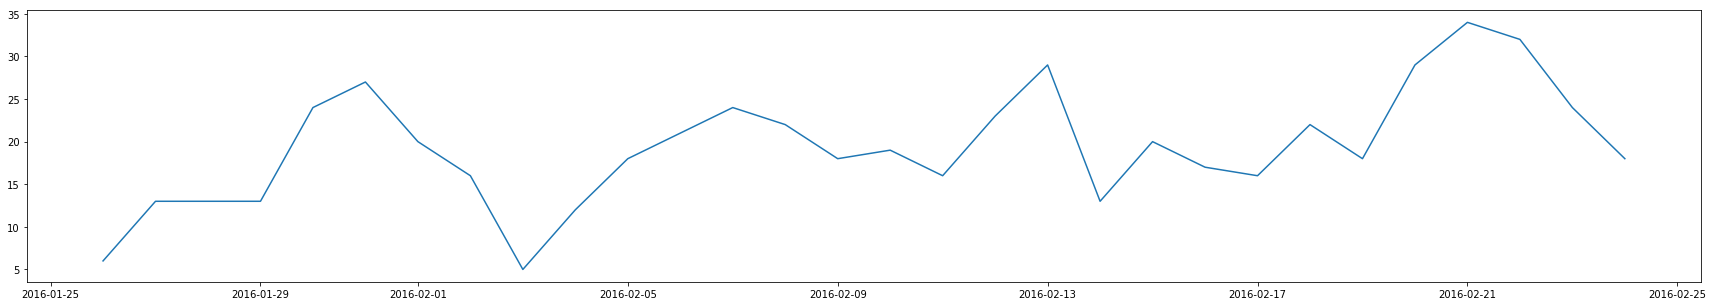

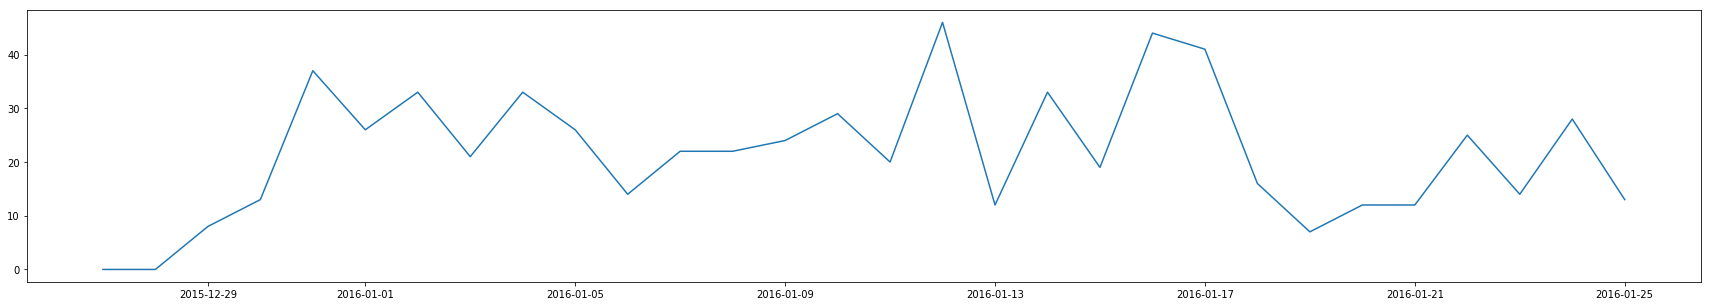

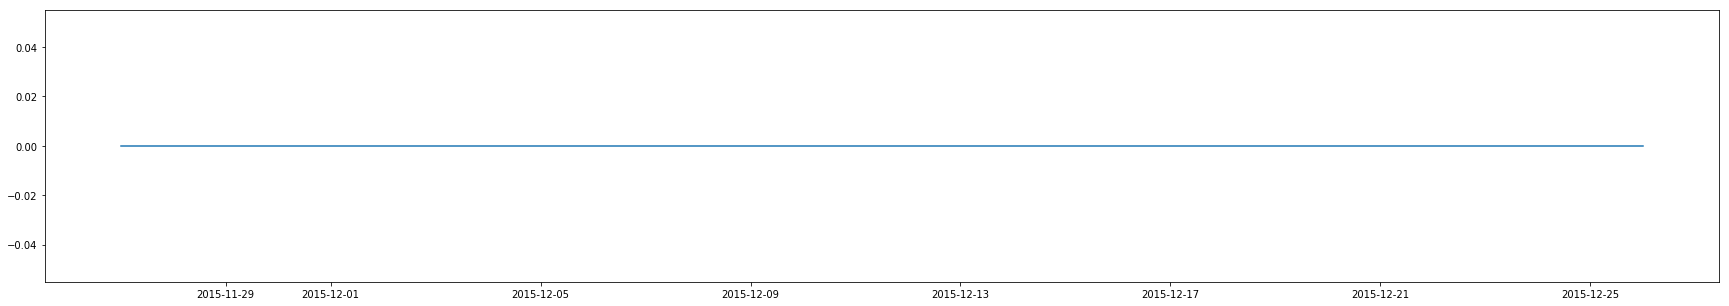

In [109]:
plt.figure(figsize=(30,5))
plt.plot(data.date[-30:], data['FOODS_3_635_CA_2_validation'][-30:])
plt.show()

for i in range(1,5):
    plt.figure(figsize=(30,5))
    plt.plot(data.date[-30*(i+1):-30*i], data['FOODS_3_635_CA_2_validation'][-30*(i+1):-30*i])
    plt.show()